In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from msresist.clustering import MassSpecClustering
from sklearn.linear_model import LogisticRegressionCV
from msresist.logistic_regression import plotClusterCoefficients, plotROC
from msresist.figures.figure2 import plotDistanceToUpstreamKinase
from msresist.pca import plotPCA
from msresist.pre_processing import filter_NaNpeptides
from msresist.figures.figureM5 import plotPeptidesByFeature, plot_NetPhoresScoreByKinGroup, plot_clusters_binaryfeatures, calculate_mannW_pvals, build_pval_matrix, TumorType

In [17]:
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

<AxesSubplot:xlabel='Weight', ylabel='AUC'>

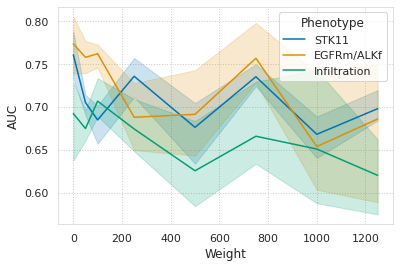

In [18]:
xx = pd.read_csv("preds_phenotypes_rs.csv").iloc[:, 1:]
xx.iloc[-3:, 1] = 1250
xx = pd.melt(xx, id_vars=["Run", "Weight"], value_vars=xx.columns[2:], var_name="Phenotype", value_name="AUC")
sns.lineplot(data=xx, x="Weight", y="AUC", hue="Phenotype")


In [2]:
import mygene

ModuleNotFoundError: No module named 'mygene'

In [3]:
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [21]:
# Import signaling data
X = filter_NaNpeptides(pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:], tmt=2)
d = X.select_dtypes(include=[float]).T
i = X.select_dtypes(include=[object])

In [22]:
# Fit DDMC
model = MassSpecClustering(i, ncl=30, SeqWeight=100, distance_method="Binomial", random_state=7).fit(d)

In [23]:
centers = pd.DataFrame(model.transform()).T
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
centers = centers.T
centers.columns = np.arange(model.n_components) + 1
centers["Patient_ID"] = X.columns[4:]
centers = TumorType(centers).set_index("Patient_ID")
centers["Type"] = centers["Type"].replace("Normal", "NAT")
centers = centers.drop(19, axis=1)

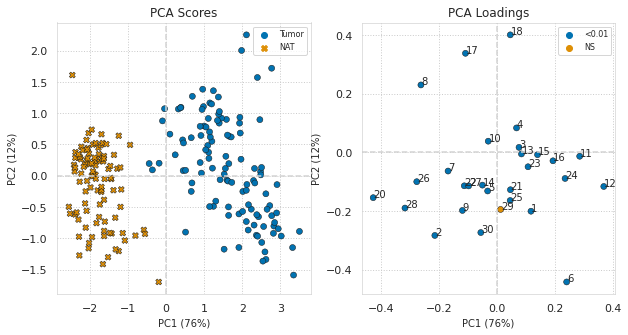

In [24]:
pvals = calculate_mannW_pvals(centers, "Type", "NAT", "Tumor")
pvals = build_pval_matrix(model.n_components, pvals)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, centers.reset_index(), 2, ["Patient_ID", "Type"], "Cluster", hue_scores="Type", style_scores="Type", pvals=pvals.iloc[:, -1].values)

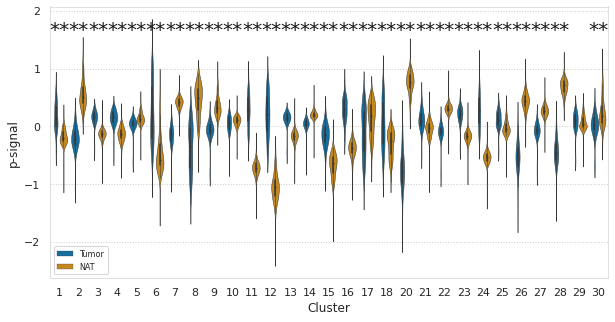

In [25]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_clusters_binaryfeatures(centers, "Type", ax, pvals=pvals, loc='lower left')

In [29]:
c = centers.select_dtypes(include=['float64'])
tt = centers.iloc[:, -1]
tt = tt.replace("NAT", 0)
tt = tt.replace("Tumor", 1)

# Logistic Regression
lr = LogisticRegressionCV(cv=3, solver="saga", max_iter=10000, n_jobs=-1, penalty="elasticnet", l1_ratios=[0.85], class_weight="balanced")

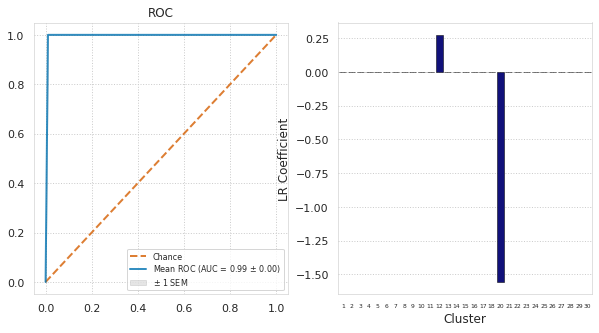

In [30]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotROC(ax[0], lr, c.values, tt, cv_folds=4, return_mAUC=False)
plotClusterCoefficients(ax[1], lr)
ax[1].set_xticklabels(centers.columns[:-1]);

/home/marcc/resistance-MS/msresist/clustering.py:170: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/home/marcc/resistance-MS/msresist/clustering.py:186: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/home/marcc/resistance-MS/msresist/clustering.py:170: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/home/marcc/resistance-MS/msresist/clustering.py:186: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


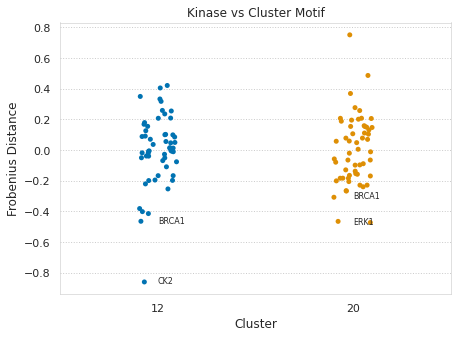

In [68]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
plotDistanceToUpstreamKinase(model, [12, 20], ax, num_hits=2)

In [57]:
X["Cluster"] = model.labels()

In [55]:
from msresist.figures.figureM5 import ExportClusterFile
from msresist.figures.figure2 import store_cluster_members
store_cluster_members(X, model, "CPTAC_DDMC_35CL_W100_MembersCluster", ["Gene", "Sequence", "Position"])

In [59]:
def ExportClusterFile(cluster):
    """Export cluster SVG file for NetPhorest and GO analysis."""
    c = pd.read_csv("msresist/data/cluster_members/CPTAC_DDMC_35CL_W100_MembersCluster" + str(cluster) + ".csv")
    c["pos"] = [s.split(s[0])[1].split("-")[0] for s in c["Position"]]
    c["res"] = [s[0] for s in c["Position"]]
    c.insert(4, "Gene_Human", [s + "_HUMAN" for s in c["Gene"]])
    c = c.drop(["Position"], axis=1)
    drop_list = ["NHSL2", "MAGI3", "SYNC", "LMNB2", "PLS3", "PI4KA", "SYNM", "MAP2", "MIA2", "SPRY4", "KSR1", "RUFY2", "MAP11",
                 "MGA", "PRR12", "PCLO", "NCOR2", "BNIP3", "CENPF", "OTUD4", "RPA1", "CLU", "CDK18", "CHD1L", "DEF6", "MAST4", "SSR3"]
    for gene in drop_list:
        c = c[c["Gene"] != gene]
    c.to_csv("Cluster_" + str(cluster) + ".csv")

ExportClusterFile(12)
ExportClusterFile(20)

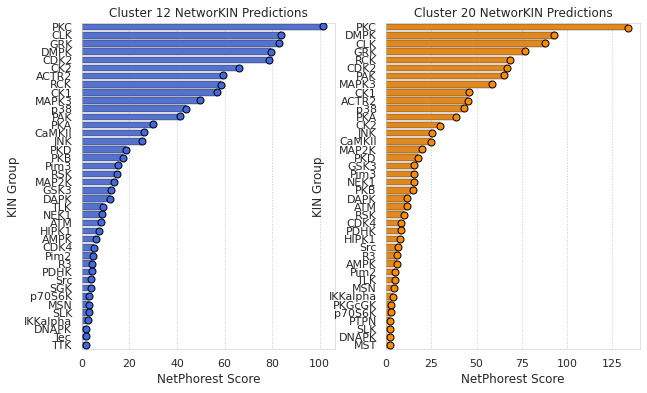

In [158]:
def plot_NetPhoresScoreByKinGroup(PathToFile, ax, n=5, title=False, color="royalblue"):
    """Plot top scoring kinase groups"""
    NPtoCumScore = {}
    X = pd.read_csv(PathToFile)
    for ii in range(X.shape[0]):
        curr_NPgroup = X["netphorest_group"][ii]
        if curr_NPgroup == "any_group":
            continue
        elif curr_NPgroup not in NPtoCumScore.keys():
            NPtoCumScore[curr_NPgroup] = X["netphorest_score"][ii]
        else:
            NPtoCumScore[curr_NPgroup] += X["netphorest_score"][ii]
    X = pd.DataFrame.from_dict(NPtoCumScore, orient='index').reset_index()
    X.columns = ["KIN Group", "NetPhorest Score"]
    X["KIN Group"] = [s.split("_")[0] for s in X["KIN Group"]]
    X = X.sort_values(by="NetPhorest Score", ascending=False).iloc[:n, :]
    sns.stripplot(data=X, y="KIN Group", x="NetPhorest Score", ax=ax, orient="h", color=color, size=7, **{"linewidth": 1, "edgecolor": "black"})
    sns.barplot(data=X, y="KIN Group", x="NetPhorest Score", ax=ax, orient="h", color=color, **{"linewidth": 0.3, "edgecolor": "black"})
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Kinase Predictions")

_, ax = plt.subplots(1, 2, figsize=(10, 6))
plot_NetPhoresScoreByKinGroup("cl12_NKIN.csv", ax[0], n=40, title="Cluster 12 NetworKIN Predictions", color="royalblue")
plot_NetPhoresScoreByKinGroup("cl20_NKIN.csv", ax[1], n=40, title="Cluster 20 NetworKIN Predictions", color="darkorange")

/home/marcc/resistance-MS/msresist/clustering.py:170: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/home/marcc/resistance-MS/msresist/clustering.py:186: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


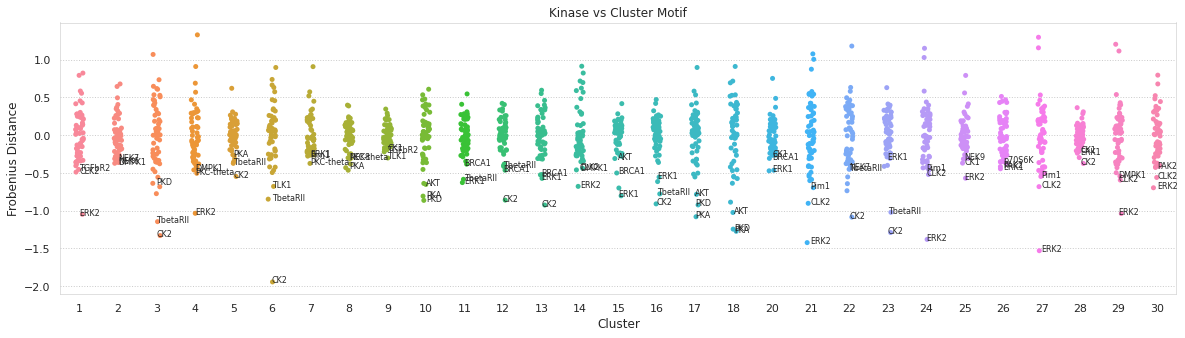

In [115]:
cc = np.arange(1, model.n_components + 1)
cc = np.delete(cc, 19 - 1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
plotDistanceToUpstreamKinase(model, cc, ax, num_hits=3)

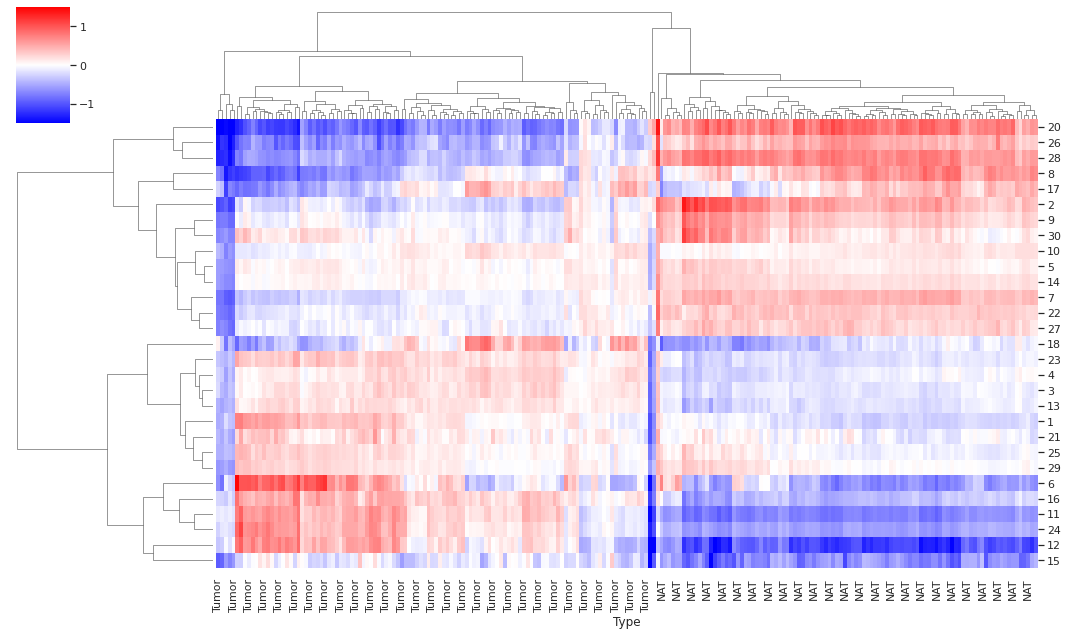

In [136]:
lim = 1.5
sns.clustermap(centers.set_index("Type").T, method="complete", cmap="bwr", vmax=lim, vmin=-lim,  figsize=(15, 9))

In [165]:
wp = pd.read_csv("CPTAC_GSEA_WP_results.csv").iloc[:, 1:]
wp.head(2)

,Clusters,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,1,WP3959,DNA IR-double strand breaks and cellular respo...,10/247,55/7850,0.000007,0.002273,0.001229,7158/55183/9656/545/4361/1869/10413/7157/4683/...,10
1,1,WP4016,DNA IR-damage and cellular response via ATR,12/247,83/7850,0.000010,0.003275,0.001229,5965/7158/9656/545/4361/1869/84142/7157/4683/1...,12


In [180]:
wpd = wp[["Clusters", "Description", "geneID"]]
wpd = wpd[wpd["Clusters"] == 20]
arr = wpd[["geneID"]].values[0]
bpAr = wpd[["Description"]].values

In [184]:
bpAr[1][0]

'VEGFA-VEGFR2 signaling pathway'

In [268]:
import mygene

def make_BPtoGenes_table(X, cluster):
    d = X[["Clusters", "Description", "geneID"]]
    d = d[d["Clusters"] == cluster]
    gAr = d[["geneID"]].values
    bpAr = d[["Description"]].values
    mg = mygene.MyGeneInfo()
    BPtoGenesDict = {}
    for ii, arr in enumerate(gAr):
        gg = mg.querymany(list(arr[0].split("/")), scopes="entrezgene", fields="symbol", species="human", returnall=False, as_dataframe=True)
        BPtoGenesDict[bpAr[ii][0]] = list(gg["symbol"])
    return pd.DataFrame(dict([(k,pd.Series(v)) for k, v in BPtoGenesDict.items()]))


def plot_enriched_processes(ax, X, gsea, cluster):
    """" Plot BPs enriched per cluster """""
    cc = make_BPtoGenes_table(gsea, cluster)
    cl = X[X["Cluster"] == cluster].set_index("Gene")
    dfs = []
    for ii in range(cc.shape[1]):
        ss = cl.loc[cc.iloc[:, ii].dropna()].reset_index()
        ss["Process"] = cc.columns[ii]
        dfs.append(ss)

    out = pd.concat(dfs).set_index("Process").select_dtypes(include=[float]).T
    out["Type"] = centers.iloc[:, -1]
    out["Type"] = out["Type"].replace(0, "NAT")
    out["Type"] = out["Type"].replace(1, "Tumor")
    dm = pd.melt(out, id_vars="Type", value_vars=out.columns, var_name="Process", value_name="mean log(p-signal)")
    dm.iloc[:, -1] = dm.iloc[:, -1].astype(float)
    sns.boxplot(data=dm, x="Process", y="mean log(p-signal)", hue="Type", ax=ax)
    ax.set_xticklabels([textwrap.fill(t, 10) for t in list(cc.columns)], rotation=0)


querying 1-12...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.


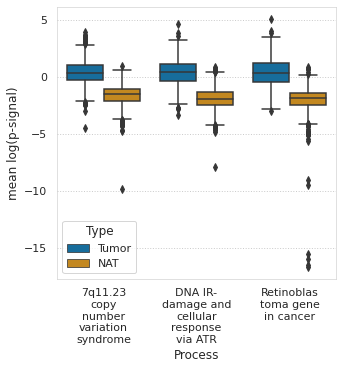

In [270]:
wp = pd.read_csv("CPTAC_GSEA_WP_results.csv").iloc[:, 1:]

_, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_enriched_processes(ax, X, wp, 12)

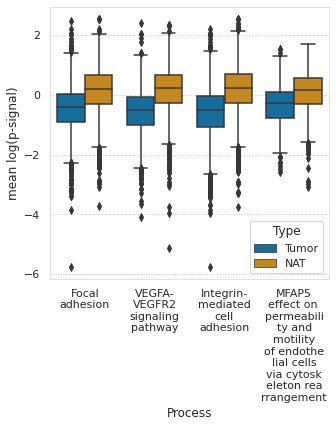

In [264]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(data=dm, x="Process", y="mean log(p-signal)", hue="Type", ax=ax)
ax.set_xticklabels([textwrap.fill(t, 10) for t in list(cc.columns)], rotation=0);